In [1]:
#DATASET="rec_mu2e.CRV_wideband_cosmics-noadc.CRVWB-006_014.root"
DATASET="rec_mu2e.CRV_wideband_cosmics-noadc.CRVWB-007ext.root"

In [2]:
from mu2etools import wideband
from mu2etools import *
import matplotlib.cm as cm
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages

processor = wideband.DataProcessor(fixtimes=True)
ar = processor.getData(DATASET, max_workers=10, step_size="10GB", nfiles=-1)

Processing file: rec.mu2e.CRV_wideband_cosmics-noadc.CRVWB-000-011-000.002048_009.root - 100.0% complete

In [3]:
list_febID = ar['febID'].to_list()
FEBID = min(list_febID, key=lambda x: len(x))

NFEBS=len(FEBID)
print("Dataset: %s"%DATASET)
print("Number of FEBs: %d"%NFEBS)
print("List of FEBs: %s"%FEBID)

Dataset: rec_mu2e.CRV_wideband_cosmics-noadc.CRVWB-007ext.root
Number of FEBs: 6
List of FEBs: [25, 17, 22, 14, 20, 1]


In [4]:
for var in ['PEs', 'PEsTemperatureCorrected', 'calibConstants', 'calibConstantsTemperatureCorrected', 
            'biasVoltagesAvg', 'febID', 'meanTemperatures', 'signalsTemperatureCorrected', 'FWHMs', 'FWHMsTemperatureCorrected',
            'chi2s', 'chi2sTemperatureCorrected'
           ]:
    # Use only first common FEBs 
    ar[var] = ar[var][:, :NFEBS]
    # Converts arrays from variable-length dimensions to fixed-length dimensions explicitly 
    ar[var] = ak.to_regular(ar[var], axis=1)

In [5]:
# Get indices sorted by 'runNumber'
sorted_indices = ak.argsort(ar['runNumber'])
# Apply sorting to entire array
ar = ar[sorted_indices]

In [6]:
cut = (ar['timestamp'] > 0)
median_b = np.median(ar['biasVoltagesAvg'][cut], axis=0)
cut1 = np.abs(ar['biasVoltagesAvg'][cut] - median_b) < 0.05 # Allow 50 mV fluctiuations 
cut2 = np.all(np.all(cut1, axis=1), axis=1)
ar_ = ar[cut2]

In [7]:
# --- Configuration ---
num_febs = NFEBS
num_channels = 64
sec_per_year = 3.154e7
correct_PE_by_SPE = False  # Set this to False to disable correction

# Extract timestamps
timestamps = ar_['timestamp'].to_numpy().astype('datetime64[s]')
time_seconds = (timestamps - timestamps[0]).astype(float)

# Data arrays
pes_array = ar_['PEsTemperatureCorrected'].to_numpy()
spe_array = ar_['calibConstantsTemperatureCorrected'].to_numpy()
feb_ids_array = ar_['febID'].to_numpy()

# SPE Mask: deviations > 2% from SPE median
spe_median = np.median(spe_array, axis=0)
spe_mask = np.abs((spe_array - spe_median) / spe_median) > 0.02

# Optionally correct PE by SPE factor
if correct_PE_by_SPE:
    correction_factors = spe_array / spe_median  # SPE correction factor
    pes_array_corrected = pes_array / correction_factors
else:
    pes_array_corrected = pes_array.copy()

In [8]:
# Initialize DataFrame
results = []

# Output PDF
pdf_filename = DATASET.replace(".root", ".pdf")

with PdfPages(pdf_filename) as pdf:
    for feb_idx in range(num_febs):
        feb_id_unique = np.unique(feb_ids_array[:, feb_idx])[0]

        for channel in range(num_channels):
            # Masks and data
            mask_ch = spe_mask[:, feb_idx, channel]
            pes_ch = pes_array_corrected[:, feb_idx, channel]
            spe_ch = spe_array[:, feb_idx, channel]
            
            spe_norm = spe_ch / np.mean(spe_ch)
            pes_masked = np.ma.masked_array(pes_ch, mask=mask_ch)

            # Valid points for aging fit
            valid_idx = (~mask_ch) & (pes_ch > 0)
            fit_times = time_seconds[valid_idx]
            fit_pes = pes_ch[valid_idx]

            # Fit exponential aging curve if enough points
            if len(fit_pes) > 2:
                log_fit_pes = np.log(fit_pes)
                B, logA = np.polyfit(fit_times, log_fit_pes, 1)
                aging_rate = -B * sec_per_year * 100  # Aging as positive number
                A = np.exp(logA)
                fit_curve = A * np.exp(B * time_seconds)
            else:
                aging_rate = np.nan
                fit_curve = np.full_like(time_seconds, np.nan)

            # Compute duration and dates
            first_time = timestamps[valid_idx][0]
            last_time = timestamps[valid_idx][-1]
            duration_years = (last_time - first_time).astype('timedelta64[s]').astype(float) / sec_per_year

            # Append results
            results.append({
                'FEB_ID': feb_id_unique,
                'Channel_ID': channel,
                'aging_rate': aging_rate,
                'First_timestamp': first_time,
                'Last_timestamp': last_time,
                'Duration_years': duration_years
            })

            # --- Plotting ---
            fig, ax1 = plt.subplots(figsize=(10, 5))

            # Good PEs (corrected or original)
            label_pe = 'PEs Corrected' if correct_PE_by_SPE else 'PEs (good)'
            ax1.plot(timestamps[~mask_ch], pes_ch[~mask_ch], 'o', 
                     color='tab:blue', label=label_pe)

            # Masked PEs
            ax1.plot(timestamps[mask_ch], pes_ch[mask_ch], 'X', 
                     color='cyan', markersize=8, label='Masked PEs')

            # Aging fit
            if not np.isnan(aging_rate):
                ax1.plot(timestamps, fit_curve, '--', color='tab:blue',
                         label=f'Exp Fit ({aging_rate:.2f}%/yr)')

            ax1.set_xlabel('Time')
            ax1.set_ylabel('PEs (Temperature Corrected)', color='tab:blue')
            ax1.tick_params(axis='y', labelcolor='tab:blue')

            # Secondary axis (SPE)
            ax2 = ax1.twinx()

            # Good SPE
            ax2.plot(timestamps[~mask_ch], spe_norm[~mask_ch],
                     'o', color='red', label='Normalized SPE (good)')

            # Masked SPE
            ax2.plot(timestamps[mask_ch], spe_norm[mask_ch],
                     'X', color='magenta', markersize=8, label='Masked SPE')

            # Median SPE line
            median_spe_norm = np.median(spe_norm[~mask_ch])
            ax2.axhline(median_spe_norm, color='red', linestyle=':', linewidth=2,
                        label=f'Median SPE ({median_spe_norm:.3f})')

            ax2.set_ylabel('Normalized SPE (mean=1)', color='red')
            ax2.tick_params(axis='y', labelcolor='red')
            ax2.set_ylim(0.95, 1.05)

            plt.title(f'FEB {feb_id_unique} – Channel {channel}')
            fig.autofmt_xdate(rotation=45, ha='right')

            # Legends outside plot
            fig.tight_layout(rect=[0, 0, 0.75, 1])
            ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
            ax2.legend(loc='lower left', bbox_to_anchor=(1.02, 0))

            # Save to PDF
            pdf.savefig(fig, bbox_inches='tight')
            plt.close(fig)

# Create DataFrame and save
aging_rates_df = pd.DataFrame(results)

csv_filename = DATASET.replace(".root", ".csv")
aging_rates_df.to_csv(csv_filename, index=False)

print(f"All plots saved to {pdf_filename}")
print(f"Aging rates saved to {csv_filename}")

All plots saved to rec_mu2e.CRV_wideband_cosmics-noadc.CRVWB-007ext.pdf
Aging rates saved to rec_mu2e.CRV_wideband_cosmics-noadc.CRVWB-007ext.csv


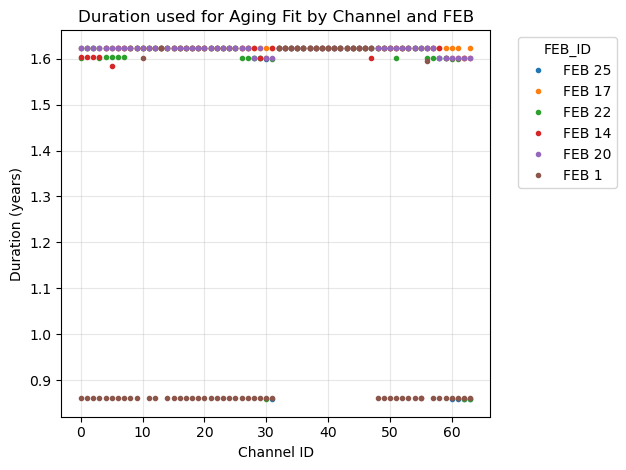

In [9]:
# Plot each FEB separately
for feb_id in aging_rates_df['FEB_ID'].unique():
    subset = aging_rates_df[aging_rates_df['FEB_ID'] == feb_id]
    plt.plot(subset['Channel_ID'], subset['Duration_years'], '.', label=f'FEB {feb_id}')

plt.xlabel('Channel ID')
plt.ylabel('Duration (years)')
plt.title('Duration used for Aging Fit by Channel and FEB')
plt.grid(alpha=0.3)
plt.legend(title='FEB_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


In [10]:
mean = aging_rates_df['aging_rate'].mean()
std = aging_rates_df['aging_rate'].std()
aging_rates_df.query(f'aging_rate>{mean}+2*{std}')

,FEB_ID,Channel_ID,aging_rate,First_timestamp,Last_timestamp,Duration_years
61,25,61,8.009846,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334
63,25,63,9.005845,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334
159,22,31,9.985293,2022-10-28 07:28:59,2024-06-03 11:59:56,1.600313
189,22,61,9.402438,2022-10-28 07:28:59,2024-06-03 11:59:56,1.600313
191,22,63,9.253885,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334


In [11]:
aging_rates_df.query(f'aging_rate<{mean}-2*{std}')

,FEB_ID,Channel_ID,aging_rate,First_timestamp,Last_timestamp,Duration_years
31,25,31,-4.807769,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334
60,25,60,-2.565730,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334
62,25,62,-10.074709,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334
187,22,59,-1.712000,2022-10-27 17:36:22,2024-06-03 11:59:56,1.601896
190,22,62,-4.720555,2022-10-28 07:28:59,2023-09-06 15:26:22,0.858334
272,20,16,-1.787969,2022-10-27 17:36:22,2024-06-11 10:47:18,1.623673
319,20,63,-1.064150,2022-10-27 17:36:22,2024-06-03 11:59:56,1.601896
350,1,30,-1.168491,2022-10-27 17:36:22,2023-09-06 15:26:22,0.859918
372,1,52,-1.987598,2022-10-27 17:36:22,2023-09-06 15:26:22,0.859918
374,1,54,-0.504194,2022-10-27 17:36:22,2023-09-06 15:26:22,0.859918


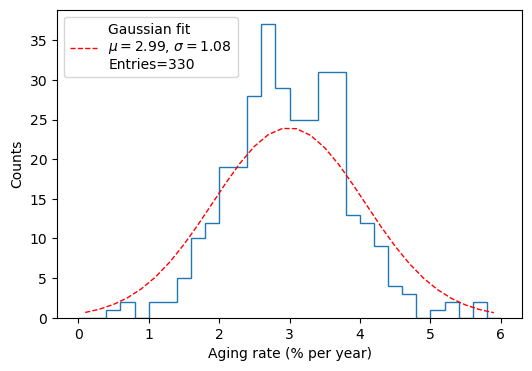

In [12]:
# Extract aging rates, excluding NaN values
median_time = aging_rates_df['Duration_years'].median()
min_duration = median_time - 0.1
data = aging_rates_df.query(f'Duration_years > {min_duration}')['aging_rate'].dropna()

# Fit Gaussian
mu, sigma = norm.fit(data)

pdf_filename = pdf_filename.replace(".pdf", "-summary.pdf")

with PdfPages(pdf_filename) as pdf:
    fig, ax1 = plt.subplots(figsize=(6, 4))    
    # Histogram data
    counts, bins, _ = plt.hist(data, bins=30, range=(0, 6), density=False, histtype='step')
    
    # Gaussian curve
    bin_centers = (bins[:-1] + bins[1:]) / 2
    gauss_fit = norm.pdf(bin_centers, mu, sigma) * np.sum(counts) * (bins[1] - bins[0])
    
    # Plot Gaussian fit (with total entries in legend)
    plt.plot(bin_centers, gauss_fit, 'r--', linewidth=1, 
             label=f'Gaussian fit\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$\nEntries={len(data)}')
    
    plt.xlabel('Aging rate (% per year)')
    plt.ylabel('Counts')
    plt.legend()
    pdf.savefig(fig, bbox_inches='tight')
